# Activation functions

## Environment setup

Define some helper methods to plot a single activation function and a bunch of them in a grid

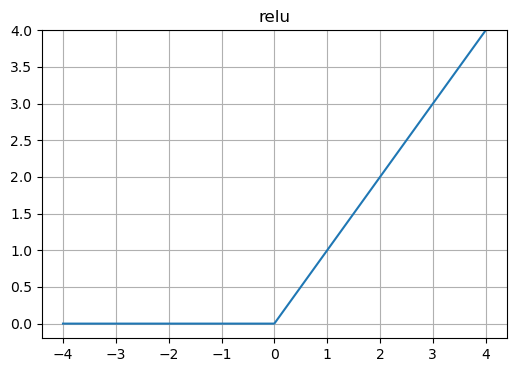

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_single_activation(
        activation_func, 
        ax=None, 
        x_range=(-4, 4), 
        y_range=(-2, 2), 
        num_points=1000, 
        title=None,
        **kwargs
):
    """
    Plots a single activation function on the provided axes, if any, otherwise create one.
    """

    if title is None:
        title = activation_func.__name__

    standalone = False
    if ax is None:
        standalone = True

    if standalone:
        # Create a figure and axis externally
        fig, ax = plt.subplots(figsize=(6, 4))

    x = np.linspace(x_range[0], x_range[1], num_points)
    y = activation_func(x, **kwargs)

    # Check if the output is multi-dimensional
    if y.ndim > 1:
        for i in range(y.shape[-1]):  # Plot each output separately
            ax.plot(x, y[:, i], label=f'{activation_func.__name__} output {i+1}')
    else:
        ax.plot(x, y, label=activation_func.__name__)
    
    ax.set_title(title)
    ax.set_ylim(y_range)
    ax.grid(True)

    if standalone:
        plt.show()

def relu(x):
    return np.maximum(0, x)

plot_single_activation(relu, y_range=(-0.2, 4))

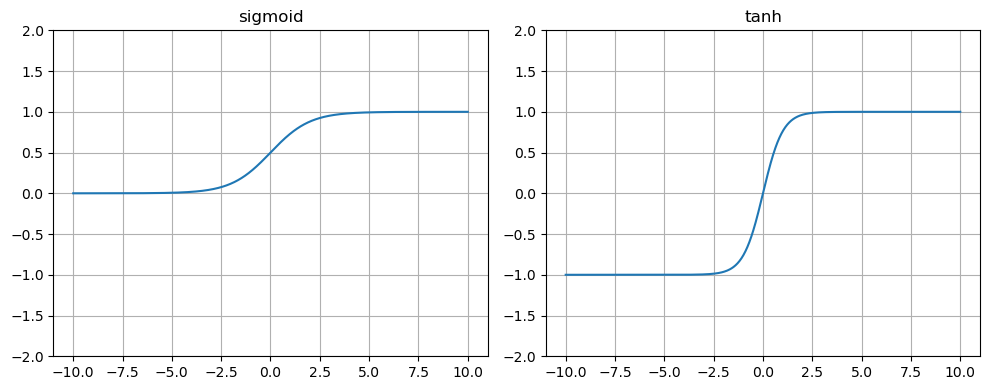

In [4]:
def plot_activation_functions_grid(
        functions_list, 
        grid_shape=(2, 2), 
        x_range=(-4, 4), 
        y_range=(-2, 2), 
        num_points=1000, 
        titles=None,
        **kwargs
):
    """
    Plot multiple activation functions in a grid
    """

    rows, cols = grid_shape
    
    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of multi-dimensional axes array
    
    if titles is None:
        titles = [func.__name__ for func in functions_list]

    for i, func in enumerate(functions_list):
        if i < len(axes):
            plot_single_activation(func, axes[i], x_range, y_range, num_points, titles[i], **kwargs)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


# Sigmoid (sig) Activation Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Hyperbolic Tangent (tanh) Activation Function
def tanh(x):
    return np.tanh(x)

activation_functions = [sigmoid, tanh]
titles = ['sig', 'tanh']
plot_activation_functions_grid(activation_functions, grid_shape=(1, 2), x_range=(-10, 10))


## The dying ReLU porblem

When the input to a neuron is negative, the gradient will be zero. This means that gradient descent will not update the weights so long as the input remains negative. A smaller learning rate helps solve this problem.



## Rectified Lienar Functions

These activation functions are based on variants of the ReLU function, which rectifies negative values while maintaining positive values unchanged.

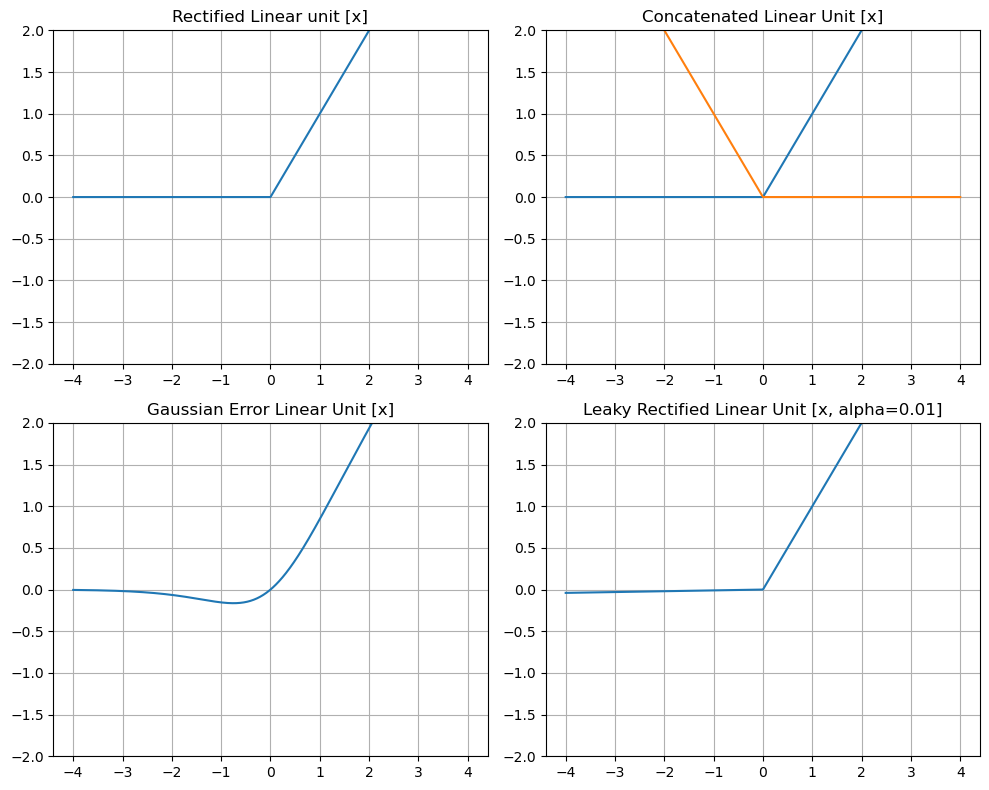

In [6]:
def relu(x, **kwargs):
    """
    Rectified Linear Unit.
    Timeless classic.
    """
    return np.maximum(0, x)

def crelu(x, **kwargs):
    """
    Concatenated ReLU. 
    This function preserves both positive and negative phase information while
    enforcing non-saturated (avoid regions where the output becomes insensitive
    to changes in the input - plateau) non-linearity. Using the CReLU doubles 
    the size of the input to the next layer, increasing the number of parameters 
    but it was showed to improve accuracy on image recognition tasks in the lower 
    convolutional layers.
    """
    x_pos = relu(x).reshape(-1, 1)
    x_neg = relu(-x).reshape(-1, 1)
    return np.concatenate([x_pos, x_neg], axis=-1)

def gelu(x, **kwargs):
    """
    Gaussian Error Linear Unit.
    This can be seen as a smoothed version of the ReLU and is particularly useful 
    for models that benefit from smooth, differentiable activation functions.
    """
    # return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    return x * sigmoid(1.702 * x) # This is an approximation

def leaky_relu(x, leaky_relu_alpha=0.01, **kwargs):
    """
    Leaky ReLU.
    Motivated by the desire to have gradients where the ReLU would have none (solve
    dying ReLU problem) but the gradients are very small and therefore vulnerable to 
    the vanishing gradients problem in deep networks.
    """
    return np.where(x > 0, x, leaky_relu_alpha * x)

def prelu(x, alpha, **kwargs):
    """
    Parametric ReLU.
    Essentially the same thing as a leaky ReLU but alpha is a learnable parameter.
    """
    return np.where(x > 0, x, alpha * x)

activation_functions = [relu, crelu, gelu, leaky_relu]
titles = [
    'Rectified Linear unit [x]', 
    'Concatenated Linear Unit [x]', 
    'Gaussian Error Linear Unit [x]',
    'Leaky Rectified Linear Unit [x, alpha=0.01]',
]
plot_activation_functions_grid(
    activation_functions, 
    titles=titles,
    grid_shape=(2, 2),
    alpha = 0.01
)

## Exponential-based functions

These functions involve exponential operations and are useful for smoother, more gradual activations compared to ReLU variants.

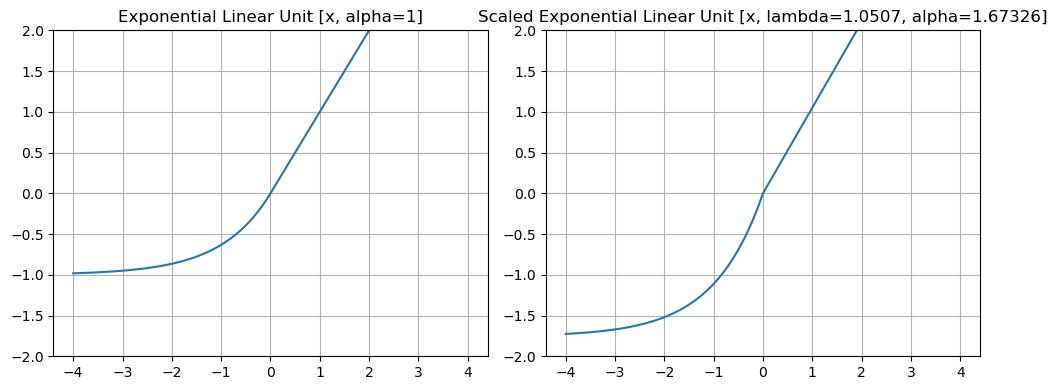

In [7]:
def elu(x, elu_alpha=1):
    """
    Exponential Linear Unit.
    Compared to ReLUs, ELUs have a mean activation closer to zero which is helpful. 
    However, this advantage is probably nullified by batch normalization.
    The more gradual decrease of the gradient should also make them less susceptible 
    to the dying ReLU problem (gradient is 0), although they will suffer from the 
    vanishing gradients problem instead (gradient becomes smaller and smaller).
    """

    return np.where(x > 0, x, elu_alpha * (np.exp(x) - 1))

def selu(x, selu_lambda=1.0507, selu_alpha=1.67326):
    """
    Scaled Exponential Linear Unit.
    The SELU is designed to be used in networks composed of many fully-connected layers, 
    as opposed to CNNs or RNNs, the principal difference being that CNNs and RNNs stabilize 
    their learning via weight sharing. As with batch normalization, SELU activations give 
    rise to activations with zero mean and unit variance but without having to explicitly 
    normalize.
    """
    return selu_lambda * elu(x, selu_alpha)

activation_functions = [elu, selu]
titles = [
    'Exponential Linear Unit [x, alpha=1]',
    'Scaled Exponential Linear Unit [x, lambda=1.0507, alpha=1.67326]'
]
plot_activation_functions_grid(activation_functions, grid_shape=(1, 2), titles=titles)

## Sigmoid-like functions

These functions are derived from the sigmoid function.

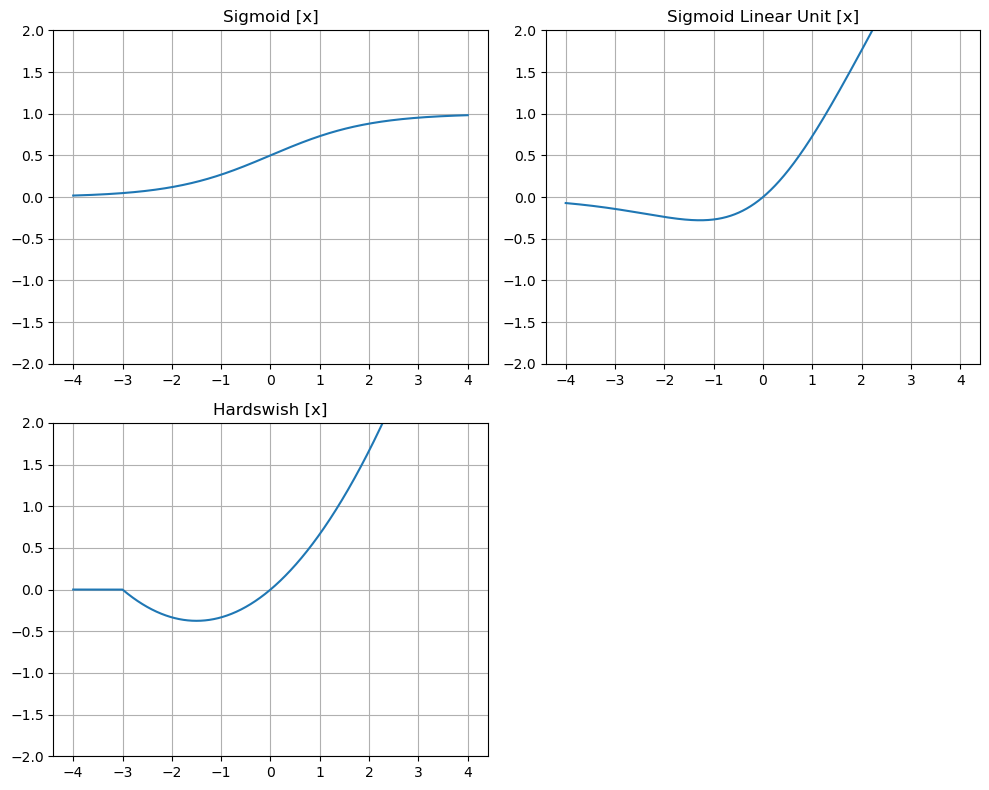

In [9]:
def sigmoid(x, **kwargs):
    """
    Sigmoid (Logistic) function.
    Classic sigmoid function with values in range (0, 1). It has problems with saturation. 
    This makes vanishing and exploding gradients a problem and initialization extremely important.
    """
    return 1 / (1 + np.exp(-x))

def silu(x, **kwargs):
    """
    Sigmoid Linear Unit.
    Combines the input with the sigmoid of the input for smoother, non-monotonic behavior.
    """
    return x * sigmoid(x)

def swish(x, swish_beta, **kwargs):
    """
    Swish Activation Function.
    Beta is a learnable parameter. 
    """
    return x / (1 + np.exp(-swish_beta * x))

def hardswish(x):
    """
    Approximation of the Swish function.
    This is faster to compute.
    """
    result = np.zeros_like(x)

    # Condition 1: x < -3
    result[x < -3] = 0

    # Condition 2: -3 <= x < 3
    mask = (x >= -3) & (x < 3)
    result[mask] = (x[mask] * (x[mask] + 3)) / 6

    # Condition 3: x >= 3
    result[x >= 3] = x[x >= 3]

    return result

activation_functions = [sigmoid, silu, hardswish]
titles = [
    'Sigmoid [x]',
    'Sigmoid Linear Unit [x]',
    'Hardswish [x]'
]
plot_activation_functions_grid(activation_functions, grid_shape=(2, 2), titles=titles)

## Misc functions

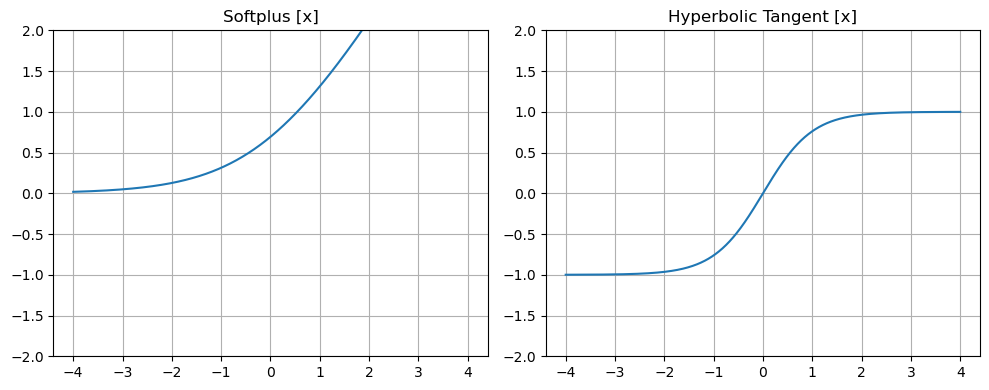

In [11]:
def softplus(x):
    """
    Softplus.
    The softplus function is a smooth approximation to the ReLU.
    Unlike ReLU, which abruptly transitions at zero, softplus is a smooth and differentiable function, 
    making it easier to optimize in deep learning. Softplus does not saturate for large positive 
    inputs, allowing gradients to flow well during backpropagation. It still suffers from the 
    vanishing gradient problem (for x approaching negative infinity, the output values become
    smaller and smaller).
    """
    return np.log(1 + np.exp(x))


def tanh(x):
    """
    Hyperbolic Tangent.
    The output of the tanh function ranges from -1 to 1, making it zero-centered, which can help 
    with convergence during training.
    """
    return np.tanh(x)

activation_functions = [softplus, tanh]
titles = [
    'Softplus [x]',
    'Hyperbolic Tangent [x]',
]
plot_activation_functions_grid(activation_functions, grid_shape=(1, 2), titles=titles)